In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/churn-modelling/Churn_Modelling.csv


In [2]:
##Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, lars_path
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, make_scorer, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from xgboost.sklearn import XGBRegressor
from sklearn.naive_bayes import GaussianNB

In [3]:
#Data Import
data=pd.read_csv('../input/churn-modelling/Churn_Modelling.csv',index_col='RowNumber')

In [4]:
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
data.Geography.value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [6]:
data.shape

(10000, 13)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


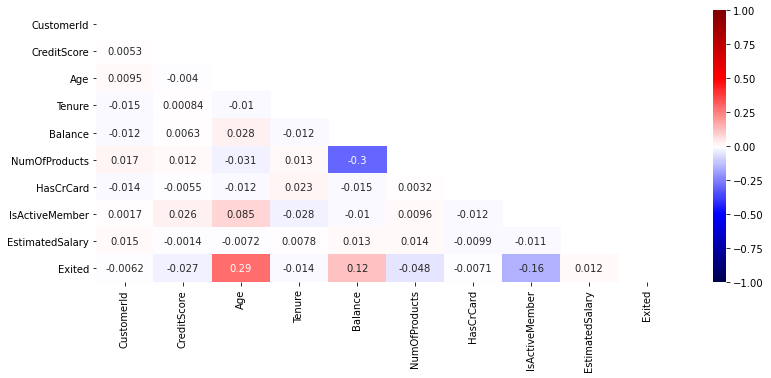

In [8]:
mask=np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(13, 5))
sns.heatmap(data.corr(), mask=mask, cmap='seismic', annot=True, vmin=-1, vmax=1,)

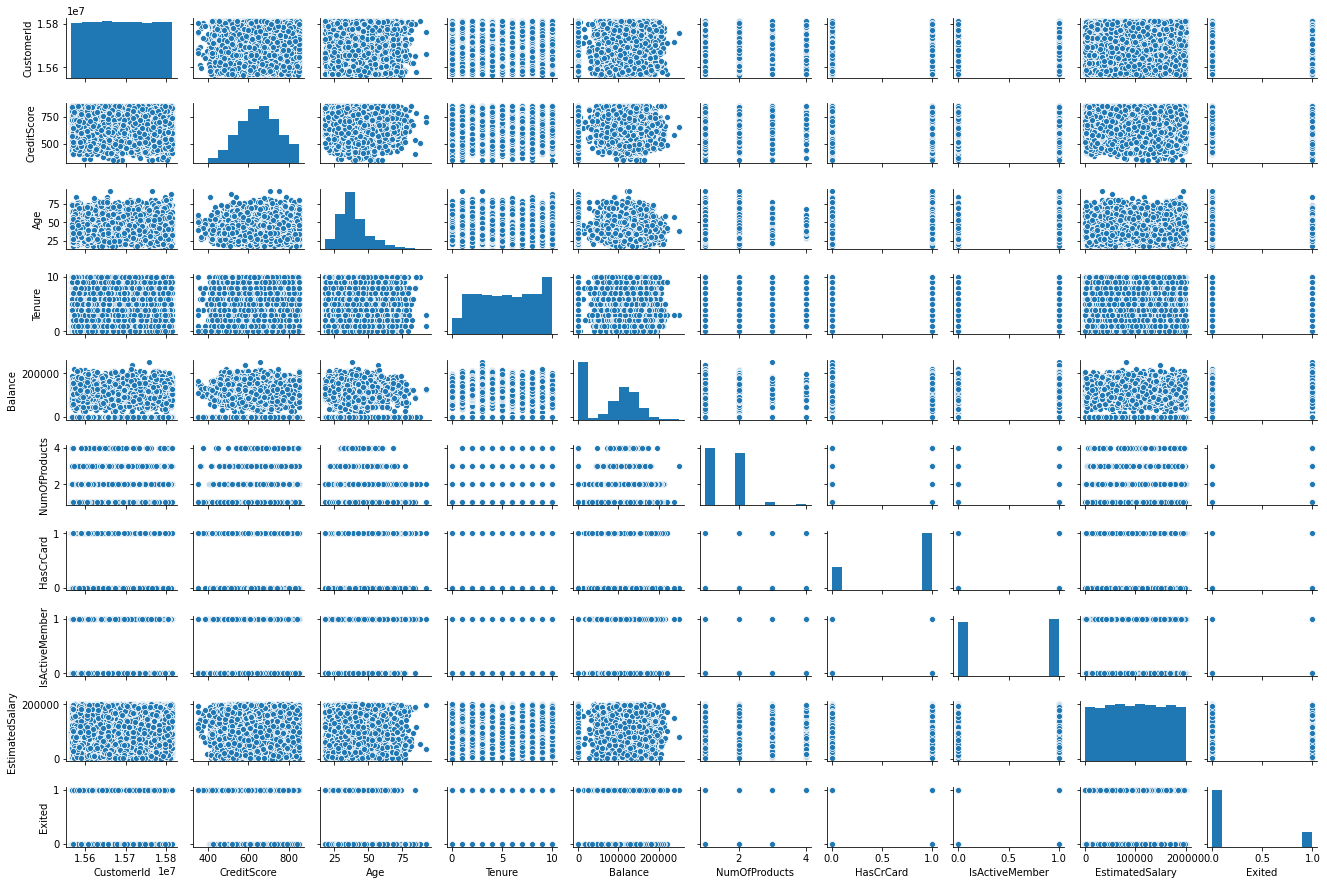

In [9]:
sns.pairplot(data, height=1.2, aspect=1.5)

In [10]:
data.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

In [11]:
#The Target column
y=data['Exited']
y.head()

RowNumber
1    1
2    0
3    1
4    0
5    0
Name: Exited, dtype: int64

In [12]:
#Remove unnecessary columns for X
X=data.drop(['CustomerId','Surname','Exited'],axis='columns')
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
RowNumber,,,,,,,,,,
1,619,France,Female,42,2,0.00,1,1,1,101348.88
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
3,502,France,Female,42,8,159660.80,3,1,0,113931.57
4,699,France,Female,39,1,0.00,2,0,0,93826.63
5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [13]:
#Transform categorical date to numerical with one-hot
X_numerical=pd.get_dummies(X)
X_numerical.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
RowNumber,,,,,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0
2,608,41,1,83807.86,1,0,1,112542.58,0,0,1,1,0
3,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,0
4,699,39,1,0.00,2,0,0,93826.63,1,0,0,1,0
5,850,43,2,125510.82,1,1,1,79084.10,0,0,1,1,0


In [14]:
#Drop each of categorical first columns
X_num=X_numerical.drop(['Geography_Spain','Gender_Male'],axis='columns')
X_num.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Gender_Female
RowNumber,,,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,1,0,1
2,608,41,1,83807.86,1,0,1,112542.58,0,0,1
3,502,42,8,159660.80,3,1,0,113931.57,1,0,1
4,699,39,1,0.00,2,0,0,93826.63,1,0,1
5,850,43,2,125510.82,1,1,1,79084.10,0,0,1


In [15]:
#Scale all the numerical columns
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X_num)
X_scaled

array([[-0.32622142,  0.29351742, -1.04175968, ...,  0.99720391,
        -0.57873591,  1.09598752],
       [-0.44003595,  0.19816383, -1.38753759, ..., -1.00280393,
        -0.57873591,  1.09598752],
       [-1.53679418,  0.29351742,  1.03290776, ...,  0.99720391,
        -0.57873591,  1.09598752],
       ...,
       [ 0.60498839, -0.27860412,  0.68712986, ...,  0.99720391,
        -0.57873591,  1.09598752],
       [ 1.25683526,  0.29351742, -0.69598177, ..., -1.00280393,
         1.72790383, -0.91241915],
       [ 1.46377078, -1.04143285, -0.35020386, ...,  0.99720391,
        -0.57873591,  1.09598752]])

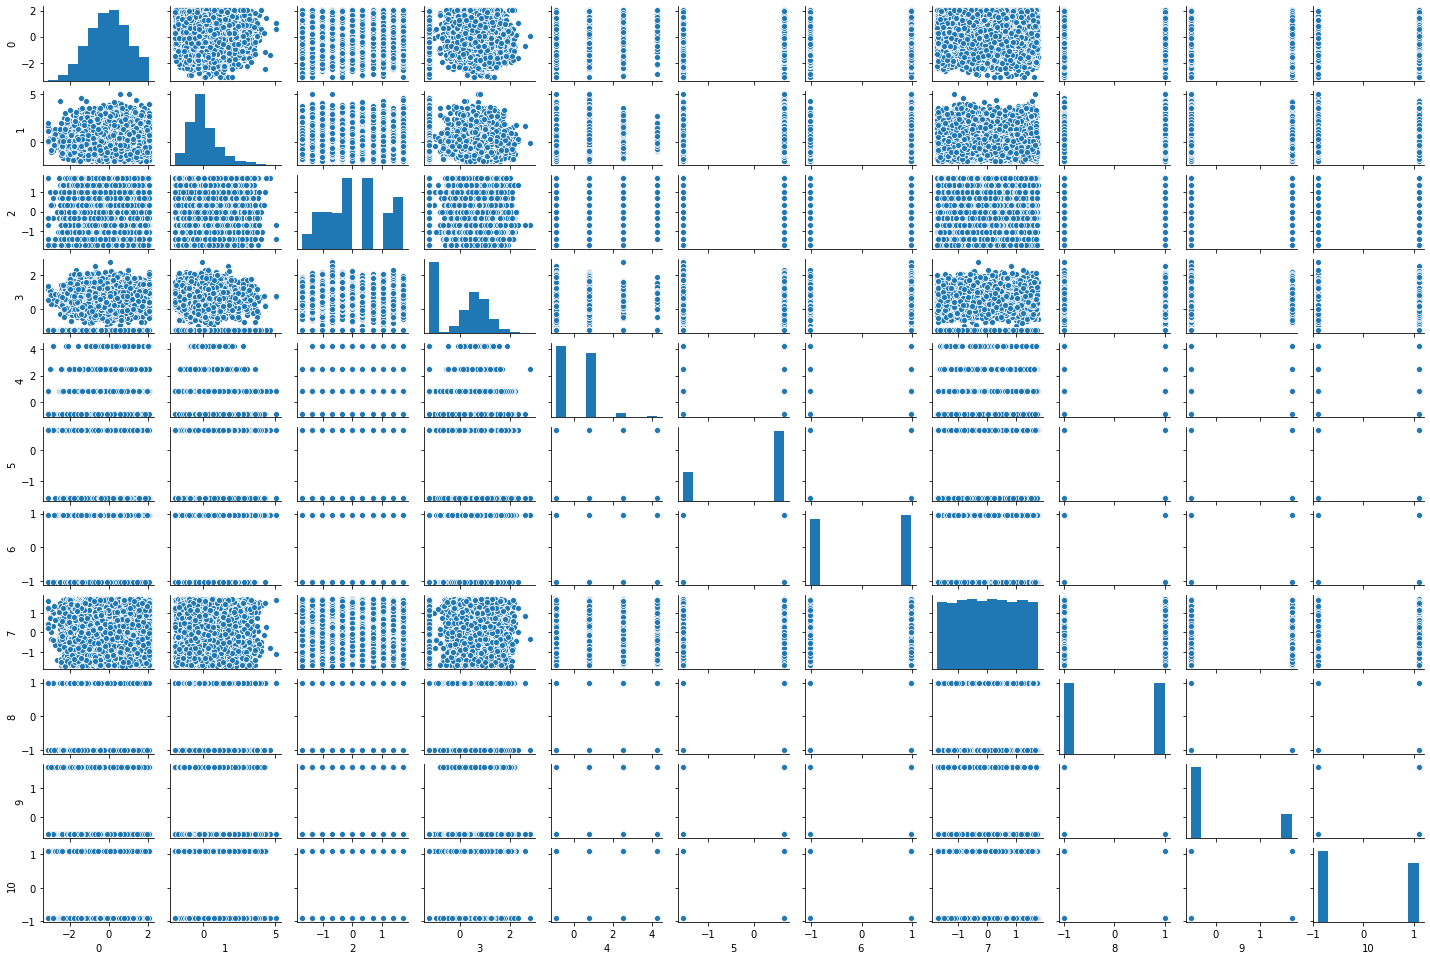

In [16]:
sns.pairplot(pd.DataFrame(X_scaled), height=1.2, aspect=1.5)

In [17]:
#Train Test Split
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size=.2, random_state=50)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=50)

In [19]:
#Lasso Path
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_scaled, y.values, method='lasso')

Computing regularization path using the LARS ...


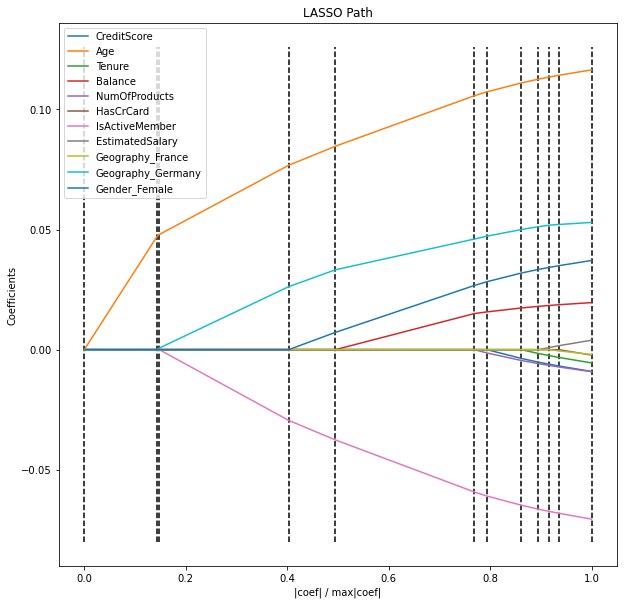

In [20]:
#Plot Lasso Path
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_num.columns)
plt.show()

In [21]:
#Gaussian Naive Bayes model
nb = GaussianNB()
nb.fit(X_train_val, y_train_val)
predictionnb=nb.predict(X_test)
f1_score(y_test, predictionnb), precision_score(y_test, predictionnb), recall_score(y_test, predictionnb)

(0.45945945945945943, 0.5795454545454546, 0.3805970149253731)

In [22]:
#Logistic Regression Model
logit = LogisticRegression(solver= 'liblinear', C=1)
logit.fit(X_train_val, y_train_val)
predictionL = logit.predict(X_test)
confusion_matrix(y_test, predictionL), f1_score(y_test, predictionL), precision_score(y_test, predictionL), recall_score(y_test, predictionL)

(array([[1533,   65],
        [ 310,   92]]),
 0.32915921288014316,
 0.5859872611464968,
 0.22885572139303484)

In [23]:
#Logistic GridSearchCV
solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
parameters = dict(solver=solver_list)
logit = LogisticRegression(random_state=34, C=1)
f1score=make_scorer(f1_score)
Grid1 = GridSearchCV(logit, parameters, scoring=f1score, cv=5)
Grid1.fit(X_train_val, y_train_val)
Grid1.best_params_, Grid1.best_score_

({'solver': 'liblinear'}, 0.3166634501914459)

In [24]:
Grid1.cv_results_

{'mean_fit_time': array([0.01819739, 0.03710642, 0.01545157, 0.04932709, 0.0317935 ]),
 'std_fit_time': array([0.00136004, 0.00171085, 0.00149515, 0.00255635, 0.00062735]),
 'mean_score_time': array([0.0022459 , 0.00220981, 0.00212531, 0.00243964, 0.00234241]),
 'std_score_time': array([5.86999905e-05, 3.28525230e-05, 7.72938766e-05, 1.56929318e-04,
        4.14501242e-05]),
 'param_solver': masked_array(data=['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'solver': 'liblinear'},
  {'solver': 'newton-cg'},
  {'solver': 'lbfgs'},
  {'solver': 'sag'},
  {'solver': 'saga'}],
 'split0_test_score': array([0.36285097, 0.36285097, 0.36285097, 0.36285097, 0.36285097]),
 'split1_test_score': array([0.30561798, 0.30561798, 0.30561798, 0.30561798, 0.30561798]),
 'split2_test_score': array([0.27906977, 0.27906977, 0.27906977, 0.27906977, 0.27906977]),
 'split3_test_score': a

In [25]:
scores = Grid1.cv_results_['mean_test_score']

for score, solver, in zip(scores, solver_list):
    print(f"{solver}: {score:.3f}")

liblinear: 0.317
newton-cg: 0.317
lbfgs: 0.317
sag: 0.317
saga: 0.317


In [26]:
#K Nearest Neighbor model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_val, y_train_val)
predictionKn=knn.predict(X_test)
f1_score(y_test, predictionKn),precision_score(y_test, predictionKn), recall_score(y_test, predictionKn)

(0.45714285714285713, 0.5369127516778524, 0.39800995024875624)

In [27]:
#KNN GridSearchCV
knn_params={
    'n_neighbors':[3,5,7,9,11],
    'weights':['uniform','distance'],
    'algorithm':['ball_tree','kd_tree','brute']
}
knng=GridSearchCV(KNeighborsClassifier(),knn_params,verbose=1,cv=5)
GridK=knng.fit(X_train_val, y_train_val)
predictionKnn=knng.predict(X_test)
f1_score(y_test, predictionKnn), precision_score(y_test, predictionKnn), recall_score(y_test, predictionKnn)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   32.2s finished


(0.45161290322580644, 0.6422018348623854, 0.3482587064676617)

In [28]:
GridK.best_params_, GridK.best_score_

({'algorithm': 'ball_tree', 'n_neighbors': 11, 'weights': 'distance'},
 0.8341249999999999)

In [29]:
#Linear SVC Model
sv=svm.LinearSVC()
sv.fit(X_train_val, y_train_val)
predictionSV=sv.predict(X_test)
f1_score(y_test, predictionSV),precision_score(y_test, predictionSV), recall_score(y_test, predictionSV)

(0.27005870841487284, 0.6330275229357798, 0.17164179104477612)

In [30]:
#SVC Radial Model
svRa=svm.SVC(kernel='rbf', gamma="scale")
svRa.fit(X_train_val, y_train_val)
predictionSVra=svRa.predict(X_test)
f1_score(y_test, predictionSVra), precision_score(y_test, predictionSVra), recall_score(y_test, predictionSVra)

(0.5361842105263158, 0.7912621359223301, 0.4054726368159204)

In [31]:
#SVC Poly Model
svPoly=svm.SVC(kernel='poly', degree=4, gamma="scale")
svPoly.fit(X_train_val, y_train_val)
predictionSVpoly=svPoly.predict(X_test)
f1_score(y_test, predictionSVpoly), precision_score(y_test, predictionSVpoly), recall_score(y_test, predictionSVpoly)

(0.5281803542673108, 0.7488584474885844, 0.4079601990049751)

In [32]:
#Random Forest Model
rand=RandomForestClassifier(n_estimators=300)
rand.fit(X_train_val, y_train_val)
predictionRand=rand.predict(X_test)
confusion_matrix(y_test, predictionRand), f1_score(y_test, predictionRand), precision_score(y_test, predictionRand), recall_score(y_test, predictionRand)

(array([[1533,   65],
        [ 218,  184]]),
 0.565284178187404,
 0.7389558232931727,
 0.4577114427860697)

In [33]:
#Random Forest with adjusted threshold
thress=0.39
predictionRandt = (rand.predict_proba(X_test)[:,1] > thress)
print("Threshold of {:6.2f}:".format(thress))
print("Precision: {:6.4f},   Recall: {:6.4f},   F1: {:6.4f}".format(precision_score(y_test, predictionRandt), 
                                                     recall_score(y_test, predictionRandt),f1_score(y_test, predictionRandt)))

Threshold of   0.39:
Precision: 0.6289,   Recall: 0.5522,   F1: 0.5881


In [34]:
confusion_matrix(y_test, predictionRandt)

array([[1467,  131],
       [ 180,  222]])

In [35]:
#XGBoost Model
xgbr = XGBRegressor(n_estimators=300, learning_rate=0.01)
xgbr.fit(X_train_val, y_train_val)
predictionXgbr=xgbr.predict(X_test)
confusion_matrix(y_test, predictionXgbr.round()), f1_score(y_test, predictionXgbr.round()), precision_score(y_test, predictionXgbr.round()), recall_score(y_test, predictionXgbr.round())

(array([[1541,   57],
        [ 219,  183]]),
 0.5700934579439253,
 0.7625,
 0.4552238805970149)

In [36]:
#XGBoost GridSearchCV
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train_val,
         y_train_val)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:   49.3s finished


[13:57:38] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:38] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:57:40] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
0.3601092955875361
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [37]:
#XGBoost Score
predictionXgbrCV=xgb_grid.predict(X_test)
precision_score(y_test, predictionXgbrCV.round()), recall_score(y_test, predictionXgbrCV.round()), f1_score(y_test, predictionXgbrCV.round())

(0.7520661157024794, 0.4527363184079602, 0.5652173913043479)

In [38]:
#Feature Importance with Random Forest
import eli5
from eli5.sklearn import PermutationImportance
perm=PermutationImportance(rand, random_state=1).fit(X_scaled,y)
eli5.show_weights(perm, feature_names=X_num.columns.tolist())

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.1509 ± 0.0051,Age
0.1041 ± 0.0012,NumOfProducts
0.0752 ± 0.0020,IsActiveMember
0.0731 ± 0.0037,Balance
0.0474 ± 0.0022,Geography_Germany
0.0459 ± 0.0018,EstimatedSalary
0.0431 ± 0.0013,CreditScore
0.0350 ± 0.0020,Gender_Female
0.0346 ± 0.0020,Tenure
0.0214 ± 0.0016,Geography_France


In [39]:
#Drop Less Importance Feature Columns
X_RF=X_numerical.drop(['Geography_Spain','Gender_Male','HasCrCard','Geography_France','Gender_Female'],axis='columns')
X_scaled_RF=scaler.fit_transform(X_RF)
X_train_val_RF, X_test_RF, y_train_val_RF, y_test_RF = train_test_split(X_scaled_RF, y, test_size=.2, random_state=50)
rand_F=RandomForestClassifier(n_estimators=300)
rand_F.fit(X_train_val_RF, y_train_val_RF)
predictionRand_F=rand_F.predict(X_test_RF)
precision_score(y_test_RF, predictionRand_F), recall_score(y_test_RF, predictionRand_F),f1_score(y_test_RF, predictionRand_F)

(0.7276264591439688, 0.4651741293532338, 0.56752655538695)

In [40]:
#Default threshold
thress=0.5
predictionRand_F = (rand_F.predict_proba(X_test_RF)[:,1] > thress)
print("Threshold of {:6.2f}:".format(thress))
print("Precision: {:6.4f},   Recall: {:6.4f},   F1: {:6.4f}".format(precision_score(y_test_RF, predictionRand_F), 
                                                     recall_score(y_test_RF, predictionRand_F),f1_score(y_test_RF, predictionRand_F)))

Threshold of   0.50:
Precision: 0.7276,   Recall: 0.4652,   F1: 0.5675


In [41]:
#Optimum threshold
thress=0.33
predictionRand_F = (rand_F.predict_proba(X_test_RF)[:,1] > thress)
print("Threshold of {:6.2f}:".format(thress))
print("Precision: {:6.4f},   Recall: {:6.4f},   F1: {:6.4f}".format(precision_score(y_test_RF, predictionRand_F), 
                                                     recall_score(y_test_RF, predictionRand_F),f1_score(y_test_RF, predictionRand_F)))

Threshold of   0.33:
Precision: 0.5827,   Recall: 0.6045,   F1: 0.5934


In [42]:
confusion_matrix(y_test_RF, predictionRand_F)

array([[1424,  174],
       [ 159,  243]])